In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Mays Limited Report.xls')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Row_ID            9994 non-null   int64  
 1   Order_ID          9994 non-null   object 
 2   Order_Date        9994 non-null   object 
 3   Ship_Date         9994 non-null   object 
 4   Ship_Mode         9994 non-null   object 
 5   Customer_ID       9994 non-null   object 
 6   Customer_Name     9994 non-null   object 
 7   Segment           9994 non-null   object 
 8   City              9994 non-null   object 
 9   State             9994 non-null   object 
 10  Postal_Code       9994 non-null   int64  
 11  Region            9994 non-null   object 
 12  Product_ID        9994 non-null   object 
 13  Category          9994 non-null   object 
 14  Sub_Category      9994 non-null   object 
 15  Product_Name      9994 non-null   object 
 16  Sales             9994 non-null   float64


In [4]:
df.head(2)

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,City,State,...,Product_Name,Sales,Quantity,Discount,Profit,Shipping_Days,Order_Year,Order_Month,Order_Day,Delayed_Shipping
0,1,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,...,Bush Somerset Collection Bookcase,261.959991,2,0.0,41.913601,4,2021,11,8,False
1,2,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,...,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.940002,3,0.0,219.582001,4,2021,11,8,False


In [5]:
df.describe()

,Row_ID,Postal_Code,Sales,Quantity,Discount,Profit,Shipping_Days,Order_Year,Order_Month,Order_Day
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858000,3.789574,0.156203,28.656896,4.958675,2020.722233,7.809686,15.468181
std,2885.163629,32063.693350,623.245098,2.225110,0.206452,234.260108,1.747722,1.123555,3.284654,8.747914
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978027,1.000000,2019.000000,1.000000,1.000000
25%,2499.250000,23223.000000,17.280001,2.000000,0.000000,1.728750,4.000000,2020.000000,5.000000,8.000000
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500,5.000000,2021.000000,9.000000,15.000000
75%,7495.750000,90008.000000,209.940002,5.000000,0.200000,29.364000,6.000000,2022.000000,11.000000,23.000000
max,9994.000000,99301.000000,22638.480469,14.000000,0.800000,8399.975586,8.000000,2022.000000,12.000000,31.000000


In [6]:
#Change date datatype to datetime

df.Order_Date=pd.to_datetime(df.Order_Date)
df.Ship_Date=pd.to_datetime(df.Ship_Date)

In [7]:
# Create 'Month_Name' and 'Day_of_Week' columns

df['Month_Name'] = df['Order_Date'].dt.month_name()
df['Day_of_Week'] = df['Order_Date'].dt.day_name()

In [8]:
# Drop 'Order_Month' and 'Order_Day' columns

df.drop('Order_Month', axis=1, inplace=True)
df.drop('Order_Day', axis=1, inplace=True)

In [9]:
# Change 'Month_Name' and 'Day_of_Week' column names

existing_cols = {
    'Month_Name':'Order_Month',
    'Day_of_Week':'Order_Day'
}

In [10]:
# Create `Year-Month` column.

df['Year_Month'] = df['Order_Date'].apply(lambda x: x.strftime("%Y-%m"))

In [11]:
df.rename(columns=existing_cols, inplace=True)

In [12]:
# Reorder columns

new_columns = ['Row_ID','Order_ID','Order_Date','Ship_Date','Ship_Mode','Customer_ID','Customer_Name','Segment','City','State',
              'Postal_Code','Region','Product_ID','Category','Sub_Category','Product_Name','Sales','Quantity','Discount','Profit',
              'Shipping_Days','Delayed_Shipping','Order_Year','Order_Month','Order_Day','Year_Month']

In [13]:
df = df[new_columns]
df.head(2)

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,City,State,...,Sales,Quantity,Discount,Profit,Shipping_Days,Delayed_Shipping,Order_Year,Order_Month,Order_Day,Year_Month
0,1,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,...,261.959991,2,0.0,41.913601,4,False,2021,November,Monday,2021-11
1,2,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,...,731.940002,3,0.0,219.582001,4,False,2021,November,Monday,2021-11


#### Visualize Data to analyse trend and seasonality

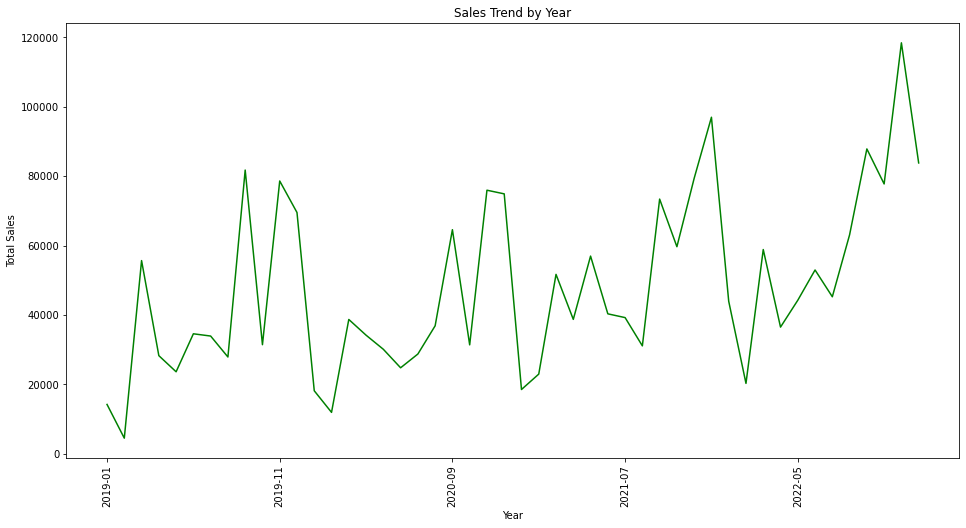

In [14]:
# Annual Sales Trend

Sales_Trend_By_Year = pd.DataFrame(df.groupby(by=['Year_Month']).sum())['Sales']

plt.figure(figsize=(16, 8))
Sales_Trend_By_Year.plot(kind='line', color='green')

plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title("Sales Trend by Year")

plt.xticks(rotation=90)
plt.show()

**Insight:**
- This charts shows that the data is seasonal with more sales occuring towards the ending of each year.
- The business also witnessed an overtime growth in sales. 

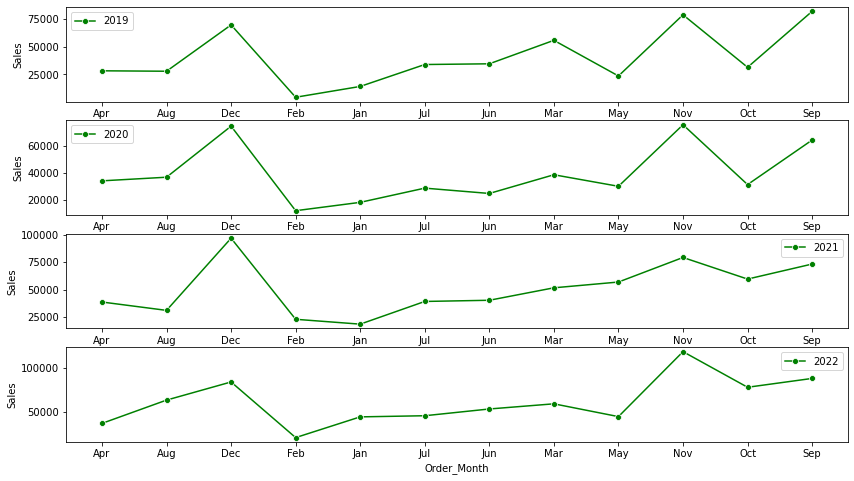

In [15]:
# Each Year Monthly Sales Trend

Annual_Monthly_Sales_Trend = df.groupby(by=['Order_Year', 'Order_Month']).sum()

Charta = Annual_Monthly_Sales_Trend.reset_index()
Charta['Order_Month'] = Charta.Order_Month.apply(lambda x:x[:3])
Annual_Monthly_Sales_Trend = Charta.groupby(by=['Order_Year', 'Order_Month']).sum()['Sales']

# plot
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 8))

yrs = [2019, 2020, 2021, 2022]
for i in range(4):
    yr = yrs[i]
    Charta = Annual_Monthly_Sales_Trend.loc[yr]
    ax[i] = sns.lineplot(x= Charta.index, y=Charta.values, data=Charta, ax=ax[i], label=yr, marker="o", color="green")
    ax[i].set_ylabel('Sales')

plt.show()

**Insight:**

- There is a monthly sales trend which sees an annual spike in sales in the months of September, November and December.

### Extreme Gradient Boosting (XGBoost)

In [16]:
# Group sales by Order Date

xgb_sales = pd.DataFrame(df.groupby(by=['Order_Date']).sum()['Sales'])
xgb_sales.shape

(1237, 1)

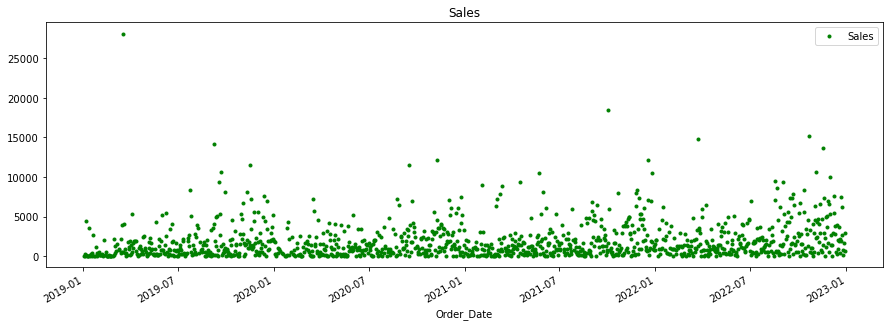

In [17]:
# Visualize sales trend

xgb_sales.plot(style='.',
        figsize=(15, 5),
        color='green',
        title='Sales')
plt.show()

###### Train/Test Split

In [18]:
train = xgb_sales.loc[xgb_sales.index < '01-01-2022']
test = xgb_sales.loc[xgb_sales.index >= '01-01-2022']

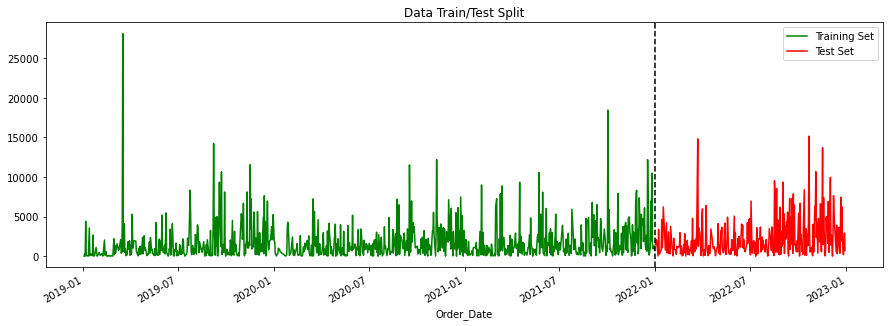

In [19]:
#Visualizing both train and test sets

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', color='green', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set', color='red')
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

#### Feature Creation

In [20]:
#     Create time series features based on time series index.

def create_features(xgb_sales):
    
    xgb_sales = xgb_sales.copy()
    xgb_sales['dayofweek'] = xgb_sales.index.dayofweek
    xgb_sales['quarter'] = xgb_sales.index.quarter
    xgb_sales['month'] = xgb_sales.index.month
    xgb_sales['year'] = xgb_sales.index.year
    xgb_sales['dayofyear'] = xgb_sales.index.dayofyear
    xgb_sales['dayofmonth'] = xgb_sales.index.day
    xgb_sales['weekofyear'] = xgb_sales.index.isocalendar().week
    return xgb_sales

xgb_sales = create_features(xgb_sales)

#### Visualize our Feature to Target Relationship

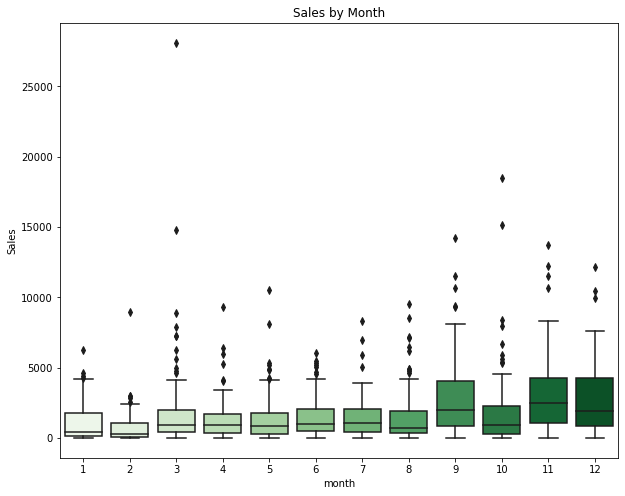

In [21]:
#Visualiza distribution of dataset

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=xgb_sales, x='month', y='Sales', palette='Greens')
ax.set_title('Sales by Month')
plt.show()

**Insight:**

- The plot reveals that there is a pick in sales towards the end of the year.

#### Create our Model based on the training data

In [22]:
# Run training and test dataset through the create feature function

train = create_features(train)
test = create_features(test)

In [23]:
# Define features

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Sales'

#dayofyear - day number as shown on calendar
#dayofweek - day category (Monday, / Tuesday...)

In [24]:
#Make Features dataset

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [25]:
#Create Regression model

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[18:54:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2812.63952	validation_1-rmse:3298.60995
[100]	validation_0-rmse:2198.97908	validation_1-rmse:2576.06814
[200]	validation_0-rmse:2071.66904	validation_1-rmse:2388.19274
[300]	validation_0-rmse:2003.38000	validation_1-rmse:2320.75329
[400]	validation_0-rmse:1956.75692	validation_1-rmse:2301.76527
[500]	validation_0-rmse:1916.10013	validation_1-rmse:2294.39510
[588]	validation_0-rmse:1876.72346	validation_1-rmse:2293.09726


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

#### Feature Importances

In [26]:
# Check for the importance of each feature

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

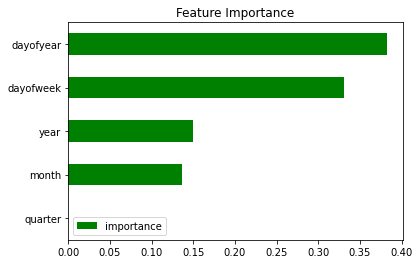

In [27]:
# Visualize feature importance

fi.sort_values('importance').plot(kind='barh', title='Feature Importance',color='green')
plt.show()

**Insight**

The model has been using the day of year, day of week, year and month features.

#### Forecast on Test

In [28]:
#Predict on test set with the train model

reg.predict(X_test)

array([1111.2404 , 1127.1494 , 1257.4929 , 1079.3948 , 1079.3948 ,
       1066.6244 , 1127.1494 , 1215.1508 , 1079.3948 , 1079.3948 ,
       1066.6244 , 1127.1494 , 1215.1508 , 1079.3948 , 1079.3948 ,
       1066.6244 , 1127.1494 , 1212.877  , 1293.9491 , 1194.7095 ,
       1194.7095 , 1181.9388 , 1160.1168 , 1379.3541 , 1171.2784 ,
       1171.2784 , 1158.5078 , 1136.6858 , 1153.511  , 1017.75616,
       1017.75616,  983.1638 , 1133.167  ,  997.4119 ,  997.4119 ,
        984.64124,  962.8196 , 1130.8931 , 1122.5673 ,  959.7589 ,
        959.7589 ,  946.9882 , 1120.2933 , 2120.3726 , 1957.5636 ,
       1839.8788 , 1827.1082 , 1805.2854 , 2000.4142 , 1907.1227 ,
       2002.6885 , 1991.7935 , 1991.7935 , 1979.0228 , 2163.1746 ,
       2609.1787 , 2008.0223 , 3046.3826 , 3046.3826 , 1852.5951 ,
       1830.7721 , 1525.9259 , 1382.9062 , 1475.7921 , 1475.7921 ,
       1463.0217 , 1441.1987 , 1136.3525 , 1053.1066 , 1382.9062 ,
       1475.7921 , 1475.7921 , 1463.0217 , 1441.1987 , 1088.60

In [29]:
# Create column called Prediction

test['prediction'] = reg.predict(X_test)

In [30]:
#Merge prediction on the test set

xgb_sales = xgb_sales.merge(test[['prediction']], how='left', left_index=True, right_index=True)

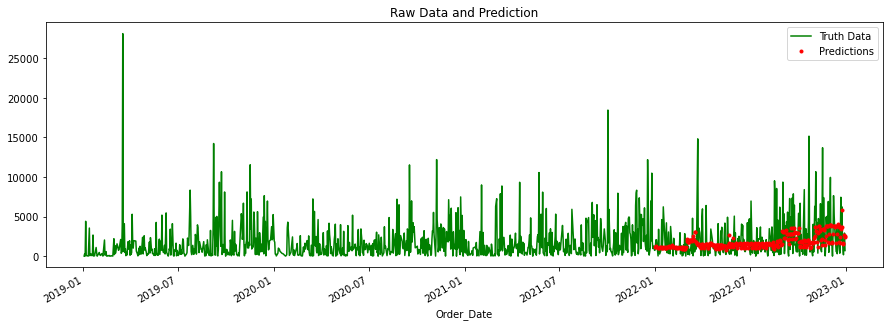

In [31]:
#Plot prediction on train dataset

ax = xgb_sales[['Sales']].plot(figsize=(15, 5), color='green')
xgb_sales['prediction'].plot(ax=ax, style='.', color='red')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

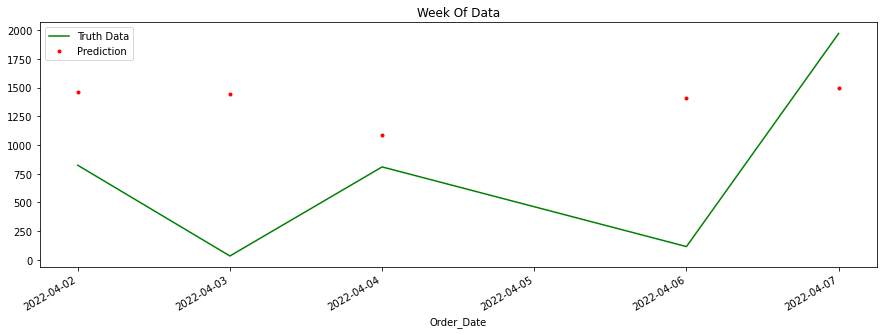

In [32]:
#Looking at one week of prediction

ax = xgb_sales.loc[(xgb_sales.index > '04-01-2022') & (xgb_sales.index < '04-08-2022')]['Sales'] \
    .plot(figsize=(15, 5), title='Week Of Data', color='green')
xgb_sales.loc[(xgb_sales.index > '04-01-2022') & (xgb_sales.index < '04-08-2022')]['prediction'] \
    .plot(style='.', color='red')
plt.legend(['Truth Data','Prediction'])
plt.show()

**Insight**

The prediction over one week follows the trend and pattern that is expected almost similar to the data trend.
In addition, the sales forecast for the next one year follows the same trend as the previous year.
This leaves room for improvement and strategic marketing as we can intensify marketing effort in products and geographical locations with the potential of generating high ROI.

#### Root Mean Square Error (RMSE) Score

In [33]:
#Run evaluation metrics

score = np.sqrt(mean_squared_error(test['Sales'], test['prediction']))
print(score)

2292.0863245678665


In [34]:
# Reduce by 2 decimal points

print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2292.09


#### Calculate Error

Look at the worst and best predicted days

In [35]:
test[TARGET] - test['prediction']

Order_Date
2022-01-01     370.587620
2022-01-02     952.404603
2022-01-03     812.779054
2022-01-06   -1045.654774
2022-01-07    2316.195158
                 ...     
2022-12-26    -903.259890
2022-12-27   -1380.931138
2022-12-28   -1067.673340
2022-12-29     533.737347
2022-12-30   -1806.115527
Length: 322, dtype: float64

In [36]:
#Take the absolute value so that the neg and pos dont matter but return the general error value for each prediction

test['error'] = np.abs(test[TARGET] - test['prediction'])

In [37]:
test['date'] = test.index.date

In [38]:
# Worst Predictions
# Recommendation would be to improve on these days going forward

test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-10-22    13461.748685
2022-03-23    13433.161690
2022-11-17    10275.998983
2022-08-17     8195.267349
2022-11-04     6987.722626
2022-08-21     6673.037086
2022-10-13     6341.775636
2022-09-02     6233.984429
2022-12-02     5995.944247
2022-08-18     5626.962672
Name: error, dtype: float64

In [39]:
# Best Prediction

test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2022-03-16     6.358657
2022-10-01    11.930948
2022-03-11    18.085492
2022-06-25    20.145785
2022-01-14    23.356787
2022-06-12    24.010407
2022-05-04    24.046241
2022-06-20    31.187414
2022-05-09    35.051712
2022-12-18    36.005698
Name: error, dtype: float64

**Recommendation**

- Dig deeper into days that are predicted to be the worst days by looking at holidays and any other factors that could affect sales within that period.

## Advanced XGBOOST

#### Time Series Cross Validation

In [40]:
tss_sales = pd.DataFrame(df.groupby(by=['Order_Date']).sum()['Sales'])

In [41]:
# Time Series cross-validator set-up
# We want to predict into 1 year

tss = TimeSeriesSplit(n_splits=3, test_size=365*1, gap=0)
df = df.sort_index()
tss

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=365)

In [42]:
#Loop over and apply to the dataset

for train_idx, val_idx in tss.split(tss_sales):
    break

In [43]:
#Check train index

train_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141])

In [44]:
#Check validation index

val_idx

array([142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
       272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
       285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
       298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
       311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 32

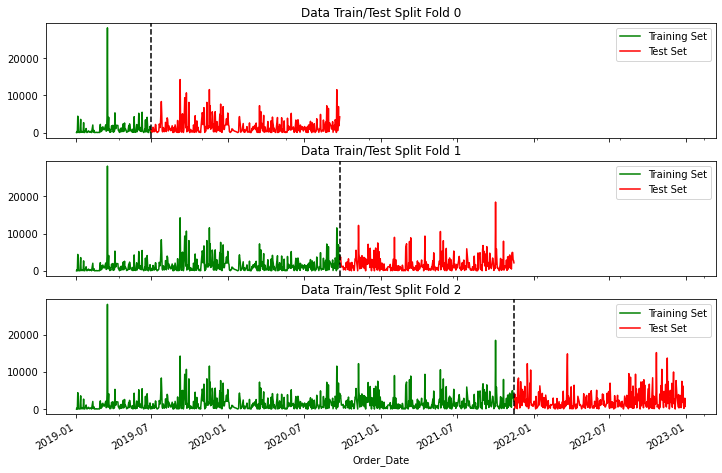

In [45]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(tss_sales):
    train = tss_sales.iloc[train_idx]
    test = tss_sales.iloc[val_idx]
    train['Sales'].plot(ax=axs[fold],
                          label='Training Set', color='green',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Sales'].plot(ax=axs[fold],
                         label='Test Set', color='red')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend(['Training Set', 'Test Set'])
    fold += 1
plt.show()

#### Forecasting Horizon Explained

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [46]:
# Create time series features based on time series index.

def create_features(tss_sales):
    tss_sales = tss_sales.copy()
    tss_sales['dayofweek'] = tss_sales.index.dayofweek
    tss_sales['quarter'] = tss_sales.index.quarter
    tss_sales['month'] = tss_sales.index.month
    tss_sales['year'] = tss_sales.index.year
    tss_sales['dayofyear'] = tss_sales.index.dayofyear
    tss_sales['dayofmonth'] = tss_sales.index.day
    tss_sales['weekofyear'] = tss_sales.index.isocalendar().week
    return tss_sales

tss_sales = create_features(tss_sales)

#### Lag Features

What was the target (x) days in the past.

In [47]:
#Create dict to map the lag features into the dataframe

target_map = tss_sales['Sales'].to_dict()

In [48]:
#Subtract timedelta(number of days into the past) from index frame
# Using 364 and not 365 because 364 can be divided by 7 to give 52 which gives the exact day of the week
#MAp on the target_map dict
# Lag for 1 year

(tss_sales.index - pd.Timedelta('364 days')).map(target_map)

Float64Index([               nan,                nan,                nan,
                             nan,                nan,                nan,
                             nan,                nan,                nan,
                             nan,
              ...
              1043.1279706954956,  6965.856981277466, 1938.2599639892578,
              10488.055006027222, 1829.4179887771606,  959.4899761676788,
                             nan, 1277.6800141334534,  773.7740015983582,
               731.7680060863495],
             dtype='float64', name='Order_Date', length=1237)

In [49]:
# Add more years and turn into a function

def add_lags(tss_sales):
    target_map = tss_sales['Sales'].to_dict()
    tss_sales['lag1'] = (tss_sales.index - pd.Timedelta('364 days')).map(target_map)
    tss_sales['lag2'] = (tss_sales.index - pd.Timedelta('728 days')).map(target_map)
    return tss_sales

In [50]:
tss_sales = add_lags(tss_sales)

#### Train Using Cross Validation

In [51]:
tss_sales.tail()

,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2
Order_Date,,,,,,,,,,
2022-12-26,814.593992,0,4,12,2022,360,26,52,959.489976,79.199999
2022-12-27,177.636001,1,4,12,2022,361,27,52,NaN,6.360000
2022-12-28,1657.350830,2,4,12,2022,362,28,52,1277.680014,3251.340065
2022-12-29,2915.533978,3,4,12,2022,363,29,52,773.774002,1381.344002
2022-12-30,713.789990,4,4,12,2022,364,30,52,731.768006,NaN


In [52]:
tss = TimeSeriesSplit(n_splits=3, test_size=365*1, gap=0)
tss_sales = tss_sales.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(tss_sales):
    train = tss_sales.iloc[train_idx]
    test = tss_sales.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'lag1','lag2']
    TARGET = 'Sales'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[18:54:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2787.52398	validation_1-rmse:2613.20058
[100]	validation_0-rmse:1818.93143	validation_1-rmse:2339.02723
[200]	validation_0-rmse:1333.25359	validation_1-rmse:2221.01062
[269]	validation_0-rmse:1149.42748	validation_1-rmse:2228.19240
[18:54:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2659.39867	validation_1-rmse:2789.64372
[100]	validation_0-rmse:2039.22832	validation_1-rmse:2243.25958
[200]	validation_0-rmse:1895.48693	validation_1-rmse:2159.47007
[300]	validation_0-rmse:1799.48751	validation_1-rmse:2152.77617
[400]	validation_0-rmse:1728.0

In [53]:
# Scores from the 3 folds

scores

[2219.2923712497477, 2151.018282590516, 2538.4101756439504]

In [54]:
#Score mean and individual score
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2302.9069
Fold scores:[2219.2923712497477, 2151.018282590516, 2538.4101756439504]


#### Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [55]:
# Retrain the model again on all data because we want to leverage on all available data for the model 
# that we would be using to forecast into the future
# Reduce n-estimator from 1000 to 300 because during the cross-validation, the model starts to over-fit around the 300th iteration

tss_sales = create_features(tss_sales)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'lag1','lag2']
TARGET = 'Sales'

X_all = tss_sales[FEATURES]
y_all = tss_sales[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[18:54:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2945.77464
[100]	validation_0-rmse:2257.40268
[200]	validation_0-rmse:2094.18092
[300]	validation_0-rmse:2021.18469
[400]	validation_0-rmse:1982.96734
[499]	validation_0-rmse:1955.34398


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [56]:
#Check for the max index value

tss_sales.index.max()

Timestamp('2022-12-30 00:00:00')

In [57]:
# Create future dataframe starting from max index value to the end date
# 'freq' can be added to predict by other variables such as hour - ('2022-08-03','2023-08-01', freq='1h')

pd.date_range('2022-12-30','2023-12-01')

DatetimeIndex(['2022-12-30', '2022-12-31', '2023-01-01', '2023-01-02',
               '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-07', '2023-01-08',
               ...
               '2023-11-22', '2023-11-23', '2023-11-24', '2023-11-25',
               '2023-11-26', '2023-11-27', '2023-11-28', '2023-11-29',
               '2023-11-30', '2023-12-01'],
              dtype='datetime64[ns]', length=337, freq='D')

In [58]:
#Create future dataframe

future = pd.date_range('2022-12-30','2023-12-01')
future_df = pd.DataFrame(index=future)

In [59]:
#Create a column to identify which of the value is future and not

future_df['isFuture'] = True
tss_sales['isFuture'] = False

In [60]:
#Conctenate future_df and tss_sales

tss_sales_and_future = pd.concat([tss_sales, future_df])

In [61]:
tss_sales_and_future

,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,isFuture
2019-01-03,16.448000,3.0,1.0,1.0,2019.0,3.0,3.0,1,NaN,NaN,False
2019-01-04,288.059993,4.0,1.0,1.0,2019.0,4.0,4.0,1,NaN,NaN,False
2019-01-05,19.535999,5.0,1.0,1.0,2019.0,5.0,5.0,1,NaN,NaN,False
2019-01-06,4407.100083,6.0,1.0,1.0,2019.0,6.0,6.0,1,NaN,NaN,False
2019-01-07,87.157997,0.0,1.0,1.0,2019.0,7.0,7.0,2,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,True
2023-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,True
2023-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,True
2023-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,True


In [62]:
# create features and add_lags on the dataframe

tss_sales_and_future = create_features(tss_sales_and_future)
tss_sales_and_future = add_lags(tss_sales_and_future)

In [63]:
#Extract the future data and creating a copy of the dataframe in the process

future_w_features = tss_sales_and_future.query('isFuture').copy()

In [64]:
future_w_features

,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,isFuture
2022-12-30,NaN,4,4,12,2022,364,30,52,731.768006,NaN,True
2022-12-31,NaN,5,4,12,2022,365,31,52,1481.827976,405.919998,True
2023-01-01,NaN,6,1,1,2023,1,1,52,2079.554017,2095.829988,True
2023-01-02,NaN,0,1,1,2023,2,2,1,2070.271974,1069.220019,True
2023-01-03,NaN,1,1,1,2023,3,3,1,NaN,255.903998,True
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,NaN,0,4,11,2023,331,27,48,6912.944003,300.591995,True
2023-11-28,NaN,1,4,11,2023,332,28,48,491.888008,970.141989,True
2023-11-29,NaN,2,4,11,2023,333,29,48,6645.282045,7365.454970,True
2023-11-30,NaN,3,4,11,2023,334,30,48,5331.178058,4684.615919,True


#### Predict the future

In [65]:
# Use regressor to run predict on future_w_features and feed it with only the Features which we've trained the model on

future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

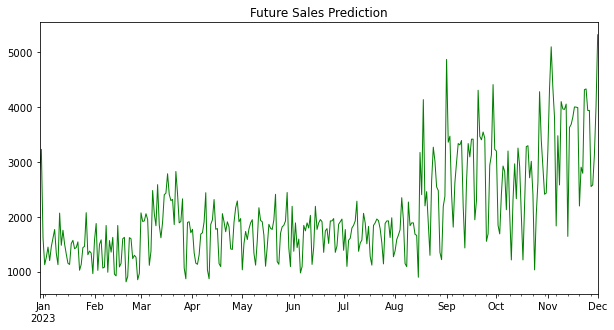

In [66]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color='green',
                               ms=1,
                               lw=1,
                               title='Future Sales Prediction')
plt.savefig('Future Sales Prediction.png')

**Insight**

- The sales forecast for the next year follows a trend that is almost similar to the previous sales trend.
- This leaves room for improvement and strategic marketing as we can intensify marketing effort in products and geographical locations with the potential of generating higher ROI.
- Resolve shipping delay issue to build customers trust in our delivery system.
- Leverage holiday period to reach out to potential customers.

### Saving Model For later

In [67]:
# Save model as .json

reg.save_model('sales_model.json')